# Hopfield Networks


Hopfield networks are a type of recurrent network that can mimic content addressable memory (CAM), where we can store memories and then, given an input, produces its match from memory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Storing and recalling patterns from memory

Consider the patterns below (smiley, heart, X, person, and note), which we will store as "memories" in our network.

Given a noisy input that at least loosely resembles one of these remembered patterns, we want our network to be able to recall the closest match.

How does it find the closest match? It could compare the input with each memory one by one and perhaps return the most similar looking one. This however becomes untenable when we have a lot of memories.

The key idea behind a Hopfield network is for the network to "naturally" converge toward the closest match by minimizing an energy function. Think about a ball rolling down a hill or a projectile flying along a parabola. These trajectories are not "selected" by searching the space of all possible trajectories - they are merely following the natural laws of physics.

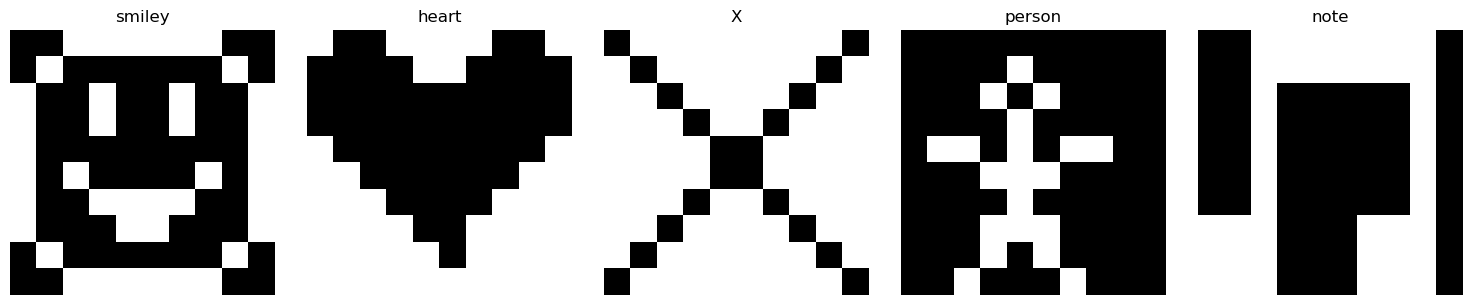

In [2]:
# patterns generated using https://tools.withcode.uk/binaryimage/
patterns = {
    "smiley": np.array([
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 1, 1, 0, 1, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 1]
    ]),
    "heart": np.array([
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ]),
    "X": np.array([
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    ]),
    "person": np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
		[1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
		[1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
		[1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
		[1, 0, 0, 1, 0, 1, 0, 0, 1, 1],
		[1, 1, 1, 0, 0, 0, 1, 1, 1, 1],
		[1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
		[1, 1, 1, 0, 0, 0, 1, 1, 1, 1],
		[1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
		[1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
    ]),
    "note": np.array([
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
		[1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
		[1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
		[1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
		[1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
		[1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
		[1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
		[0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
		[0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
		[0, 0, 0, 1, 1, 1, 0, 0, 0, 1]
    ])
}

# convert to 1, -1
def binarize_pattern(pattern):
    return np.where(pattern.flatten() == 1, 1, -1)

def show_pattern(vec, title, ax):
    img = vec.reshape(10, 10)
    ax.imshow(img, cmap="gray_r")
    ax.set_title(title)
    ax.axis("off")
    
pattern_vectors = {name: binarize_pattern(pat) for name, pat in patterns.items()}

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, (name, vec) in zip(axes, pattern_vectors.items()):
    show_pattern(vec, name, ax)

plt.tight_layout()
plt.show()

## Define a network
We define a network with 100 neurons. The network is a fully-connected, undirected graph.

In [3]:
N = 100
W = np.zeros((N, N))

### Encode the patterns into memory by setting weights optimally
The energy function for a Hopfield network is $$E(\vec{x}) = -\frac{1}{2} \vec{x}^T W\vec{x}$$

where the vector $\vec{x}$ represents the current state of the network (i.e. the values, -1 or 1, of all the neurons).

In [7]:
def energy(state, W):
    # print(W.shape, state.shape, np.dot(W, state).shape, -0.5 * (state.T @ W)@state)
    # return -0.5 * np.dot(state.T, np.dot(W, state))
    return -0.5 * (state.T @ W)@state

How do we set the "optimal" W?

In [5]:
for p in pattern_vectors.values():
    W += np.outer(p, p)

# NOTE: Diagonal of the weight matrix is all zeros because the network doesn't have
#   any self connections
np.fill_diagonal(W, 0)
M = len(pattern_vectors) # number of patterns we stored in memory
W /= M

## Recall time!
Now let's put our network to the test and determine if it can recognize the perturbed inputs we give it (i.e. can it recall the matching pattern from memory).

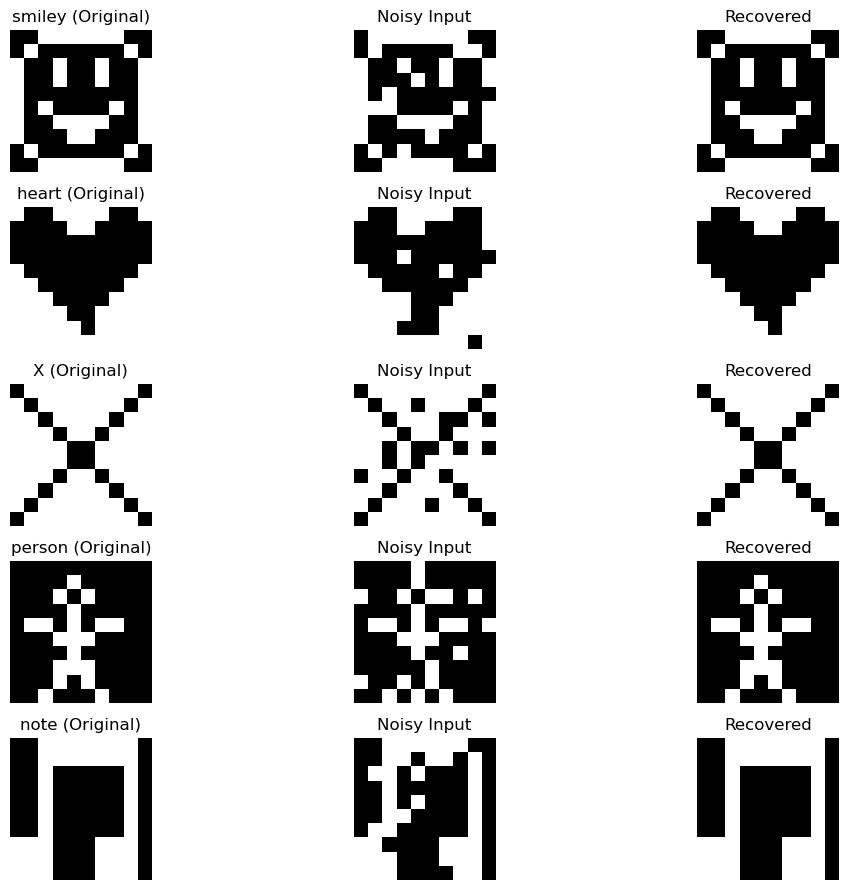

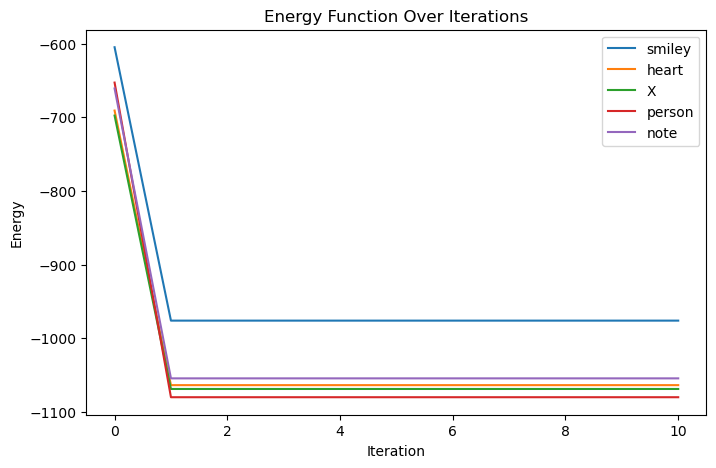

In [8]:
# function for applying random noise to create noisy input
def add_noise(pattern_vec, noise_level=0.1):
    noisy = pattern_vec.copy()
    flip_indices = np.random.choice(len(noisy), int(noise_level * len(noisy)), replace=False)
    noisy[flip_indices] *= -1
    return noisy

# function for saving energy values of each network state so we can plot it
def hopfield_recall_with_energy(W, input_pattern, steps=10):
    state = input_pattern.copy()
    energy_trace = [energy(state, W)]
    for _ in range(steps):
        for i in range(len(state)):
            raw = np.dot(W[i], state)
            state[i] = 1 if raw >= 0 else -1
        energy_trace.append(energy(state, W))
    return state, energy_trace

fig_pattern, axes_pattern = plt.subplots(len(pattern_vectors), 3, figsize=(12, 9))
fig_energy, ax_energy = plt.subplots(figsize=(8, 5))

for row_idx, (name, original) in enumerate(pattern_vectors.items()):
    noisy = add_noise(original, noise_level=0.1)
    recovered, energy_trace = hopfield_recall_with_energy(W, noisy)

    show_pattern(original, f"{name} (Original)", axes_pattern[row_idx][0])
    show_pattern(noisy, "Noisy Input", axes_pattern[row_idx][1])
    show_pattern(recovered, "Recovered", axes_pattern[row_idx][2])

    ax_energy.plot(energy_trace, label=f"{name}")

fig_pattern.tight_layout()
ax_energy.set_title("Energy Function Over Iterations")
ax_energy.set_xlabel("Iteration")
ax_energy.set_ylabel("Energy")
ax_energy.legend()
plt.show()